In [17]:
import numpy as np
from scipy.optimize import minimize, Bounds
from scipy.optimize import NonlinearConstraint, LinearConstraint

import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation, Model Formulation, and Model Execution

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 7940204.213336798
            Iterations: 17
            Function evaluations: 362
            Gradient evaluations: 13
Solution not found:  Positive directional derivative for linesearch
[161.79999986 161.79999986 161.79999986 161.79999986 161.79999986
 295.69999975 507.91520376 507.91397768 507.91397768 507.91520376
 507.91752049 507.91749068 507.91749068 507.91476215 507.90494189
 507.9278333  507.92034698 507.92124558 454.1999996  354.09999969
 343.8999997  331.19999971 269.99999976 153.19999985]
Sum rates = 9106.3
Sum res = 9106.299991984488


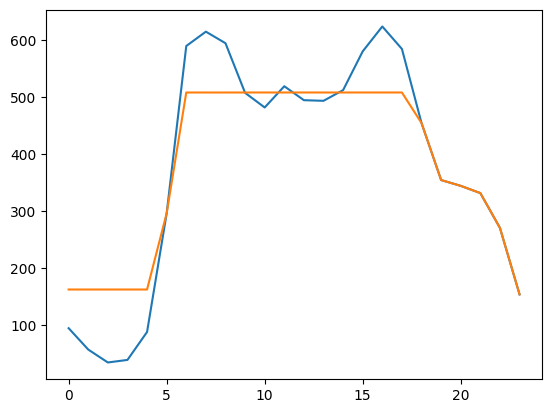

In [18]:
# Data Preparation

real_data = np.array([938, 563, 336, 381, 872, 2957,
                      5896, 6148, 5945, 5073, 4816, 5189,
                     4944, 4933, 5121, 5802, 6239, 5844,
                     4542, 3541, 3439, 3312, 2700, 1532])

# The raw data is hourly traffic volume in a highway. Since I 
# only need to use the distribution to simulate how busy a particular hour of the
# day is, I am multiplying the raw data by a factor (here it is 0.1) to roughly estimate
# the hourly hydorgen demand for a small fuel station.

h2_demands = real_data * 0.1

# Model Formulation

params = h2_demands.shape[0]

# 50000
X0 = np.full(params, 00)  # Initial guess for X

R = 2 # Arbitrary constant

# Objective function
def objective_fun(X):
    sum = 0
    for q in X:
        sum += ((q**2) * R)
    return sum

def generate_timepoint_h2_level_constraint(j):
    def timestep_h2_level_constraint(X):
        return np.sum(X[:j+1]) - np.sum(h2_demands[:j+1])
    return timestep_h2_level_constraint

C = 500 # C represents the maximum tank size. A very large number can be used to represent infinite tank size.
def generate_storage_limiter_constraint(j):
    def storage_constraint(X):
        return C - np.sum(X[:j+1]) + np.sum(h2_demands[:j+1])
    return storage_constraint

h2_level_constraints = []

for i in range(params):
    
    h2_level_constraints.append(
        {"type" : "ineq", "fun" : generate_timepoint_h2_level_constraint(i)}
    )
    h2_level_constraints.append(
        {"type" : "ineq", "fun" : generate_storage_limiter_constraint(i)}
    )
    '''
    constraints.append(
        {"type" : "ineq", "fun" : lambda input: np.sum(input[:i+1]) - np.sum(h2_demands[:i+1])}
    )'''

production_rate_bounds = [(0, np.inf)] * params

solver_log = {'obj_val': [], 'x_val': []}    

def callback_fun(x_i):
    obj_val = objective_fun(x_i)
    solver_log['obj_val'].append(obj_val)
    solver_log['x_val'].append(x_i)

# Model Execution

result = minimize(objective_fun, X0, method = "SLSQP", bounds = production_rate_bounds, constraints = h2_level_constraints,
                 options = {'disp': True, "maxiter" : 5000}, callback = callback_fun)

rates = result.x

if result.success:
    # optimized_rates = result.x
    print("Solution Rates: ", rates)
else:
    print("Solution not found: ", result.message)



print(rates)

t = np.array(range(0, params))

print("Sum rates = " + str(np.sum(h2_demands)))
print("Sum res = " + str(np.sum(rates)))

plt.plot(t, h2_demands, label = "main_demand")
plt.plot(t, rates, label = "Rates")

# plt.savefig("SLSQP_C_Inf_Initial_00_rates.png", dpi = 300)

## Simulation with Results

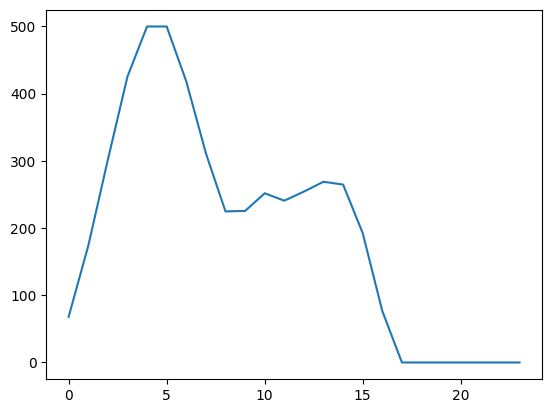

In [19]:
# Simulation with Results

sim_H2_level = 0
h2_level_arr = []

for indx in range(0, result.x.shape[0]):
    sim_H2_level += result.x[indx]
    sim_H2_level -= h2_demands[indx]
    h2_level_arr.append(sim_H2_level)
    # print(sim_H2_level)

plt.plot(t, h2_level_arr, label = "H2 level")

## Model Convergence Analysis

[np.float64(7940204.227710674), np.float64(7940204.302272824), np.float64(7940204.435263603), np.float64(7940204.468257037), np.float64(7940204.290664832), np.float64(7940204.254752402), np.float64(7940204.237684654), np.float64(7940203.593942103), np.float64(8022801.4382596), np.float64(7940204.241468618), np.float64(7940203.990441593), np.float64(7940204.00385397), np.float64(7940204.213336798)]


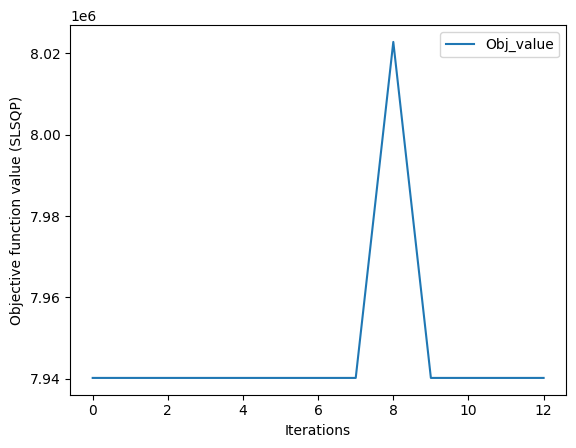

In [20]:
t_obj = range(len(solver_log["obj_val"]))
t_x_val = range(len(solver_log["x_val"]))

print(solver_log["obj_val"])
# for tt in t_obj:
#     print(tt)
# for i in t_x_val:
#     print(solver_log["x_val"][i])

plt.plot(t_obj, solver_log["obj_val"], label = "Obj_value")
plt.xlabel("Iterations")
plt.ylabel("Objective function value (SLSQP)")
plt.legend()
# plt.savefig("SLSQP_C_500_Initial_100.png", dpi = 300)